# TM10007 Assignment template

In [44]:
# Run this to use from colab environment
#!pip install -q --upgrade git+https://github.com/jveenland/tm10007_ml.git
#!pip install numpy pandas matplotlib seaborn scikit-learn scipy

## Data loading and cleaning

Below are functions to load the dataset of your choice. After that, it is all up to you to create and evaluate a classification method. Beware, there may be missing values in these datasets. Good luck!

In [45]:
# Packages
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import savgol_filter, find_peaks
from scipy.stats import shapiro
from sklearn import model_selection, feature_selection, svm
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import VarianceThreshold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.exceptions import ConvergenceWarning
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import (
    StratifiedKFold,
    learning_curve,
    GridSearchCV,
)
from sklearn.metrics import (
    accuracy_score,
    roc_curve,
    auc,
    classification_report,
)

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore",category=ConvergenceWarning)
warnings.filterwarnings("ignore", message=".*covariance matrix of class.*")

# Data load
from worclipo.load_data import load_data
df = load_data()


## Preprocessing
### Missing values & Clean-up

In [46]:
# # Drop ID column as it is not useful for training
# df.drop(columns=['ID'], inplace=True)

# Check for missing values and store them
missing_values = df[df.isna().any(axis=1)]

if not missing_values.empty:
    print(f"{missing_values.shape[0]} samples with missing values stored in missing_values")
    df = df.drop(missing_values.iloc[0:,:].index)
else:
    print("No missing values found")

# Encode the target variable
df['label'] = df['label'].map({'lipoma': 0, 'liposarcoma': 1})

No missing values found


## Data Description

In [47]:
print(f'The number of samples: {len(df.index)}')
print(f'The number of features: {len(df.columns)}')

# Find ratio lipoma - liposarcoma
print(f"Sick-Healthy ratio: {df['label'].sum()}-{df.shape[0]-df['label'].sum()}")

# Gaussian distributed featues in healthy data
df_label0 = df[df['label']==0]
not_normal_dist0 = 0
for column in df.columns[1:]:
    column_data = df_label0[column].values

    statistic, pvalue = shapiro(column_data)
    if float(pvalue) > 0.05:
        not_normal_dist0 += 1

# Gaussian distributed featues in sick data
df_label1 = df[df['label']==1]
not_normal_dist1 = 0
for column in df.columns[1:]:
    column_data = df_label1[column].values

    statistic, pvalue = shapiro(column_data)
    if float(pvalue) > 0.05:
        not_normal_dist1 += 1

# Gaussian distributed featues in all data
not_normal_dist = 0
for column in df.columns[1:]:
    column_data = df[column].values

    statistic, pvalue = shapiro(column_data)
    if float(pvalue) > 0.05:
        not_normal_dist += 1

print(f"Ratio of Gaussian/NonGaussian feature distribution in all data: {not_normal_dist} - {df.shape[1]-not_normal_dist-1}")
print(f"Ratio of Gaussian/NonGaussian feature distribution in healthy data: {not_normal_dist0} - {df_label0.shape[1]-not_normal_dist0}")
print(f"Ratio of Gaussian/NonGaussian feature distribution in sick data: {not_normal_dist1} - {df_label1.shape[1]-not_normal_dist1}")

The number of samples: 115
The number of features: 494
Sick-Healthy ratio: 58-57
Ratio of Gaussian/NonGaussian feature distribution in all data: 66 - 427
Ratio of Gaussian/NonGaussian feature distribution in healthy data: 117 - 377
Ratio of Gaussian/NonGaussian feature distribution in sick data: 86 - 408


### Data Split

In [48]:
# Split into train and test
X = df
y = df.iloc[:,0]
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.20, stratify=y, random_state = 49)
X_train.drop(columns=['label'], inplace=True)
X_test.drop(columns=['label'], inplace=True)
print(f'The number of samples in train data: {(X_train.shape[0])}')
print(f'The number of samples in test data: {(X_test.shape[0])}')

The number of samples in train data: 92
The number of samples in test data: 23


### Data distribution & Scaling

In [49]:
# Check Datadistributions & Scaling
normal = 0
outliers = 0
scaler_count = {"standard": 0, "minmax": 0, "robust":0}
scalers = {}

for column in X_train.columns:
    column_data = X_train[column].values

    # Check for normal distribtuin
    statistic, pvalue = shapiro(column_data)
    not_normal_dist = 1 if float(pvalue) <= 0.05 else 0
    if float(pvalue) > 0.05:
        normal += 1

    # Check for outliers
    Q1 = np.percentile(column_data, 25)
    Q3 = np.percentile(column_data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers_count = np.sum((column_data < lower_bound) | (column_data > upper_bound))
    if outliers_count > 0:
        outliers += 1

    # Choose appropriate scaler for each feature
    if not_normal_dist == 0:
        scalers[column] = StandardScaler()
        scaler_count["standard"] += 1
    elif not_normal_dist != 0 and outliers_count == 0:
        scalers[column] = MinMaxScaler()
        scaler_count["minmax"] += 1
    else:
        scalers[column] = RobustScaler()
        scaler_count["robust"] += 1

# Train set scaling
scaled_columns = []
for column in X_train.columns:
    column_data = X_train[column].values.reshape(-1, 1)
    scalers[column].fit(column_data)
    scaled_column = scalers[column].transform(column_data)
    scaled_columns.append(pd.Series(scaled_column.flatten(), name=column))

X_train = pd.concat(scaled_columns, axis=1)

# Test set scaling - no fitting again
scaled_columns_test = []
for column in X_test.columns:
    column_data = X_test[column].values.reshape(-1, 1)
    scaled_column = scalers[column].transform(column_data)
    scaled_columns_test.append(pd.Series(scaled_column.flatten(), name=column))

X_test = pd.concat(scaled_columns_test, axis=1)

missing_values_data = pd.DataFrame()
if not missing_values.empty:
    for column in missing_values.columns:
        column_data = missing_values[column].values.reshape(-1,1)
        scaled_column = scalers[column].transform(column_data)
        missing_values_data[column] = scaled_column.flatten
missing_values = missing_values

# Scaler usage table
scaler_data = {
    'Scaler': ['Standard', 'MinMax', 'Robust'],
    'Count': [scaler_count['standard'], scaler_count['minmax'], scaler_count['robust']]
}
scaler_df = pd.DataFrame(scaler_data)
print("Scaler Usage:")
print(scaler_df.to_string(index=False))

# Distribution ratio table
distribution_data = {
    'Type': ['Gaussian', 'Non-Gaussian'],
    'Count': [normal, X_train.shape[1] - normal]
}
distribution_df = pd.DataFrame(distribution_data)
print("\nFeature Distribution:")
print(distribution_df.to_string(index=False))

# Outlier ratio table
outlier_data = {
    'Type': ['No Outliers', 'Outliers'],
    'Count': [X_train.shape[1] - outliers, outliers]
}
outlier_df = pd.DataFrame(outlier_data)
print("\nOutlier Analysis:")
print(outlier_df.to_string(index=False))

Scaler Usage:
  Scaler  Count
Standard     88
  MinMax     29
  Robust    376

Feature Distribution:
        Type  Count
    Gaussian     88
Non-Gaussian    405

Outlier Analysis:
       Type  Count
No Outliers     86
   Outliers    407


### Feature Selection
#### Variance

In [50]:
# Feature selection based on variance
variance_selector = VarianceThreshold(threshold=0.01)
data_var= variance_selector.fit_transform(X_train.iloc[:, 1:])

print(f"Features reduced from {X_train.shape[1]} to {data_var.shape[1]} features after variation filtering")

Features reduced from 493 to 464 features after variation filtering


#### Correlation 


In [51]:
# Removing redundant features based on correlation
data_var_df = pd.DataFrame(data_var)
corr_matrix = data_var_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Drop features with correlation higher than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
data_cor = data_var_df.drop(columns=to_drop)

print(f"Features reduced from {data_var.shape[1]} to {data_cor.shape[1]} features after correlation filtering")

Features reduced from 464 to 278 features after correlation filtering


#### RFE: linear

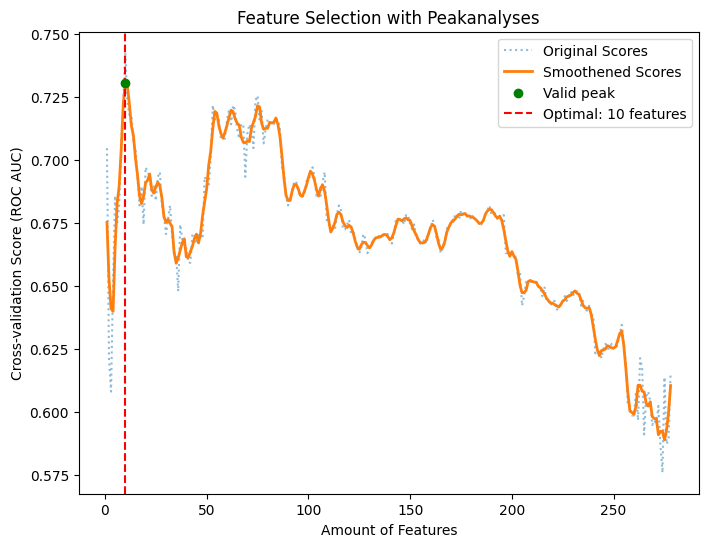

Optimal amount of features: 10


In [52]:
# Linear feature selection by RFE
est_lin = LogisticRegression(max_iter=500)

# classifications
rfecv = feature_selection.RFECV(
    estimator = est_lin, step=1,
    cv=model_selection.StratifiedKFold(4),
    scoring='roc_auc')
rfecv.fit(data_cor, y_train)

# Get CV scores
cv_scores = rfecv.cv_results_["mean_test_score"]
num_features = np.arange(1, len(cv_scores) + 1)

# Smooth scores with Savitzky-Golay
smoothed_scores = savgol_filter(cv_scores, window_length=7, polyorder=2)

# Find smoothend peaks
peaks, properties = find_peaks(smoothed_scores, height=None)

# Set thresholds for peaks and find them
max_score = np.max(smoothed_scores)
threshold = max_score * 0.95
feat_min = 5
feat_max = 20

valid_peaks = [p for p in peaks if feat_max >= num_features[p] >= feat_min and smoothed_scores[p] >= threshold]

# Select the first correct peak
if valid_peaks:
    first_peak = valid_peaks[0]
    optimal_index = first_peak

    for next_peak in valid_peaks[1:]:
        if first_peak < next_peak <= first_peak + 3:
            if smoothed_scores[next_peak] > smoothed_scores[optimal_index]:
                optimal_index = next_peak
else:
    valid_indices = np.where((num_features >= 5) & (num_features <= 25))[0]
    optimal_index = valid_indices[np.argmax(smoothed_scores[valid_indices])]
optimal_features_lin = num_features[optimal_index]

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(num_features, cv_scores, label="Original Scores", alpha=0.5, linestyle="dotted")
plt.plot(num_features, smoothed_scores, label="Smoothened Scores", linewidth=2)
plt.scatter(num_features[valid_peaks], smoothed_scores[valid_peaks], color='g', label="Valid peak", zorder=3)
plt.axvline(optimal_features_lin, color='r', linestyle="--", label=f"Optimal: {optimal_features_lin} features")
plt.xlabel("Amount of Features")
plt.ylabel("Cross-validation Score (ROC AUC)")
plt.legend()
plt.title("Feature Selection with Peakanalyses")
plt.show()

print(f"Optimal amount of features: {optimal_features_lin}")

#### Final feature selections
As the non-linear ROC AUC does not make much sense, we choose to go forward with only the linear features.

In [53]:
# Linear feature selection with Random Forest
rf = RandomForestClassifier(random_state=42, n_estimators=100, class_weight='balanced')
rf.fit(X_train, y_train)

# Feature_importance
feature_importance = rf.feature_importances_

n_importance = optimal_features_lin
important_features_lin = sorted(range(len(feature_importance)), key=lambda i: feature_importance[i], reverse=True)[:n_importance]
features = X_train.columns[important_features_lin]

# Create DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': feature_importance[important_features_lin]
})

# Visualize results
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)
print(feature_importance_df)

# Filtering in datasets
X_train = X_train[features]
X_test = X_test[features]

                                             Feature  Importance
0                    PREDICT_original_sf_volume_2.5D    0.025632
1          PREDICT_original_tf_Gabor_mean_F0.2_A0.79    0.016705
2                  PREDICT_original_sf_area_avg_2.5D    0.015509
3                  PREDICT_original_sf_area_std_2.5D    0.012165
4  PREDICT_original_vf_Frangi_full_mean_SR(1.0, 1...    0.011349
5  PREDICT_original_vf_Frangi_full_entropy_SR(1.0...    0.010409
6                PREDICT_original_tf_LBP_std_R15_P36    0.009460
7          PREDICT_original_tf_Gabor_min_F0.05_A1.57    0.009357
8         PREDICT_original_tf_Gabor_mean_F0.05_A0.79    0.008895
9          PREDICT_original_tf_Gabor_mean_F0.5_A0.79    0.008893


Checking the CoVariance matrices

In [54]:
# Make sure y_train has a column name
y_train.name = 'label'
y_train_df = pd.DataFrame(y_train)

# Combine features and labels into one DataFrame
df = pd.concat([X_train.reset_index(drop=True), y_train.reset_index(drop=True)], axis=1)

# Select data for each class
class0_df = df[df['label'] == 0].drop(columns='label')
class1_df = df[df['label'] == 1].drop(columns='label')

# Compute covariance matrices
cov_0 = class0_df.cov()
cov_1 = class1_df.cov()

# Print covariance matrix for class 0
#print("\nCovariance matrix for class 0:\n", cov_0)
off_diag_0 = cov_0.values - np.diag(np.diag(cov_0.values))
max_off_diag_0 = np.abs(off_diag_0).max()
print(f"Max off-diagonal (class 0): {max_off_diag_0:.4e}")
print("-> Features appear uncorrelated.\n" if max_off_diag_0 < 1e-5 else "-> Features are correlated.\n")

# Print covariance matrix for class 1
#print("Covariance matrix for class 1:\n", cov_1)
off_diag_1 = cov_1.values - np.diag(np.diag(cov_1.values))
max_off_diag_1 = np.abs(off_diag_1).max()
print(f"Max off-diagonal (class 1): {max_off_diag_1:.4e}")
print("-> Features appear uncorrelated.\n" if max_off_diag_1 < 1e-5 else "-> Features are correlated.\n")

# Compare the two covariance matrices
fro = np.linalg.norm(cov_0.values - cov_1.values, ord='fro')
print(f"Frobenius norm between class 0 and class 1: {fro:.4e}")
print("-> Covariances nearly equal (LDA OK).\n" if fro < 1e-3 else "-> Covariances differ (LDA assumption likely violated).\n")


Max off-diagonal (class 0): 1.4113e+03
-> Features are correlated.

Max off-diagonal (class 1): 1.1176e+02
-> Features are correlated.

Frobenius norm between class 0 and class 1: 2.3955e+07
-> Covariances differ (LDA assumption likely violated).



#### Return samples with missing values if possible

In [55]:
# Check for important features in missing data
valid_samples = missing_values[features].dropna()

if not valid_samples.empty:
    print(f"{valid_samples.shape[0]} samples from missing_values have all important features present.")

    # Encode the label
    valid_samples['label'] = valid_samples['label'].map({'lipoma': 0, 'liposarcoma': 1})

    # Append to training data
    X_train = pd.concat([X_train, valid_samples[features]], axis=0)
    y_train = pd.concat([y_train, valid_samples['label']], axis=0)

    print("Valid samples added back to training data.")

else:
    print("No valid samples with all important features found in missing_values.")

No valid samples with all important features found in missing_values.


#### Classifiers

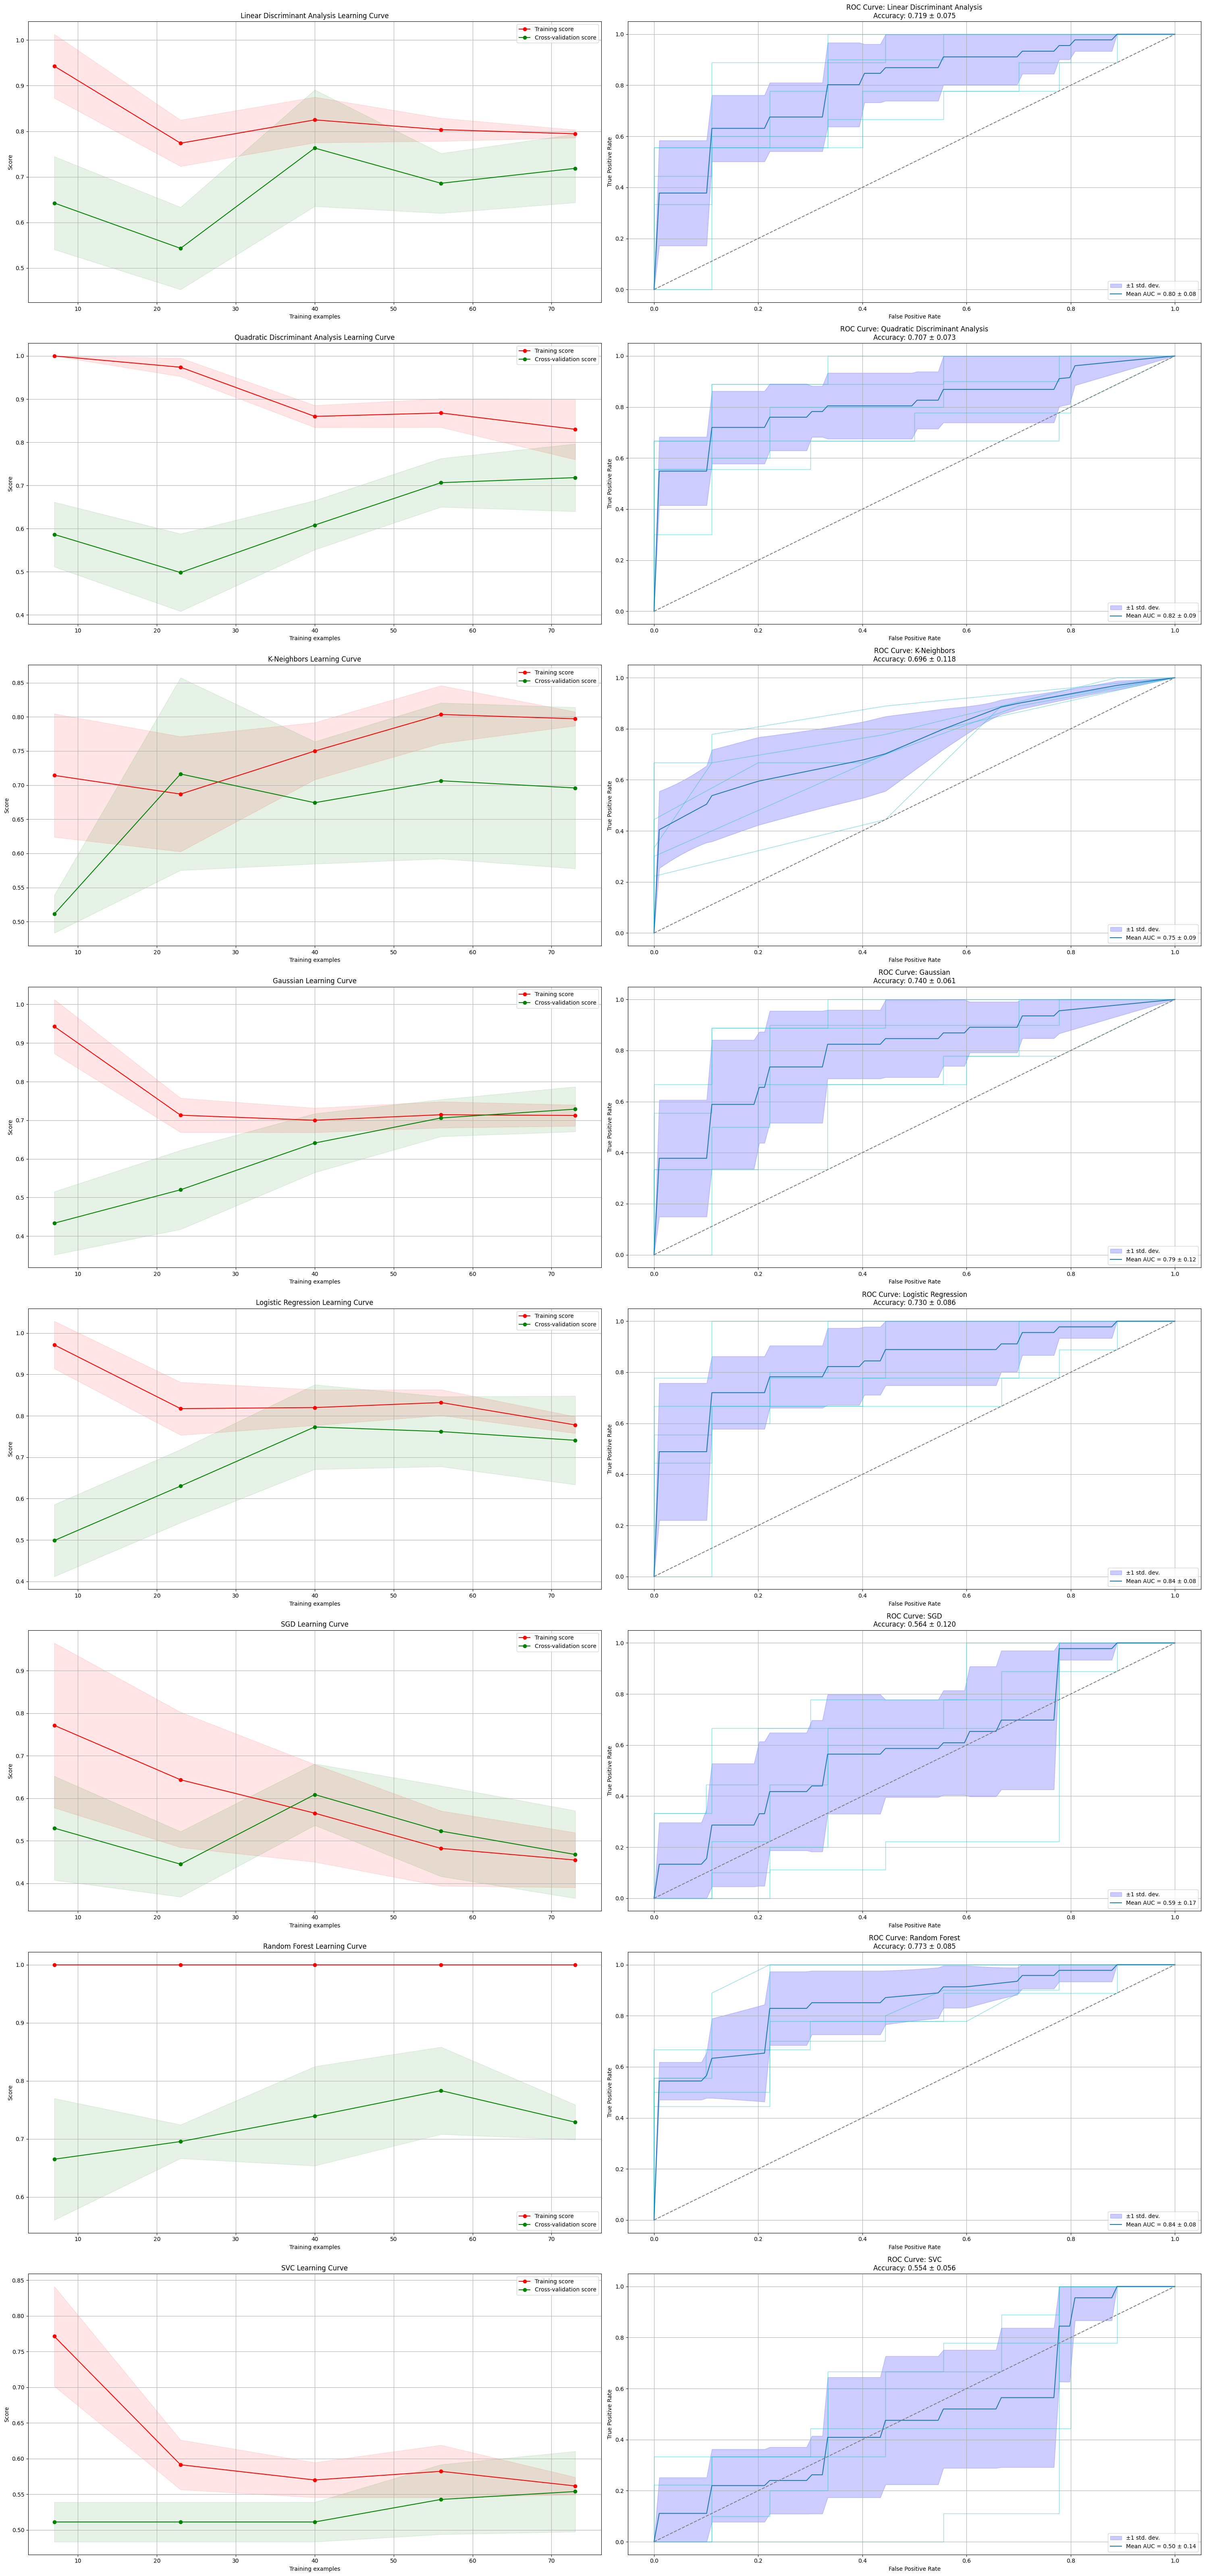

In [56]:
# Custom function to plot learning curve
def plot_learning_curve(estimator, title, Xs, Ys, axes, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    """ Generate learning curves"""

    axes.set_title(title)
    if ylim is not None:
        axes.set_ylim(*ylim)
    axes.set_xlabel("Training examples")
    axes.set_ylabel("Score")

    train_sizes, train_scores, test_scores = \
        learning_curve(estimator, Xs, Ys, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes, random_state=42)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Plot learning curve
    axes.grid()
    axes.fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes.fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes.plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes.plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes.legend(loc="best")

    return plt

# Generating Classifiers
clsfs = [LinearDiscriminantAnalysis(),QuadraticDiscriminantAnalysis(),KNeighborsClassifier(),GaussianNB(),
         LogisticRegression(),SGDClassifier(),RandomForestClassifier(),svm.SVC()]
clf_names = ["Linear Discriminant Analysis", "Quadratic Discriminant Analysis", "K-Neighbors", "Gaussian",
               "Logistic Regression", "SGD", "Random Forest", "SVC"]
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_auc_scores = {}

# Create a plot grid
fig, axes = plt.subplots(len(clsfs), 2, figsize=(30, 8*len(clsfs)))
axes = axes.flatten()  # Make it a 1D array so you can index it easily
num = 0

# Loop through classifiers
for clf, name in zip(clsfs, clf_names):
    # Get the learning Curve
    title = f"{name} Learning Curve"
    plot_learning_curve(clf, title, X_train, y_train, axes[num*2], cv = cv)
    num += 1

    # Compute ROC AUC via Cross-Validation
    mean_fpr = np.linspace(0, 1, 100)
    tprs = []
    aucs = []
    accs = []

    for train_idx, test_idx in cv.split(X_train, y_train):
        clf.fit(X_train.iloc[train_idx], y_train.iloc[train_idx])
        if hasattr(clf, "predict_proba"):
            probas = clf.predict_proba(X_train.iloc[test_idx])[:, 1]
        elif hasattr(clf, "decision_function"):
            probas = clf.decision_function(X_train.iloc[test_idx])
        else:
            continue

        fpr, tpr, _ = roc_curve(y_train.iloc[test_idx], probas)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc(fpr, tpr))

        # Calculate accuracy for this fold and store
        y_pred = clf.predict(X_train.iloc[test_idx])
        accs.append(np.mean(y_pred == y_train.iloc[test_idx]))

        # Light grey ROC line for each fold
        axes[num * 2 -1].plot(fpr, tpr, color='#17becf', lw=1, alpha=0.5)

    # Calculate statistics
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    std_tpr = np.std(tprs, axis=0)
    mean_auc = np.mean(aucs)
    std_auc = np.std(aucs)
    cv_auc_scores[name] = mean_auc
    mean_acc = np.mean(accs)
    std_acc = np.std(accs)
    cv_auc_scores[name] = mean_auc

    # Axis
    axes[num * 2 -1].fill_between(mean_fpr, np.maximum(mean_tpr - std_tpr, 0),
                np.minimum(mean_tpr + std_tpr, 1), alpha=0.2, color='blue', label='±1 std. dev.')
    axes[num * 2 -1].plot(mean_fpr, mean_tpr, label=f"Mean AUC = {mean_auc:.2f} ± {std_auc:.2f}")
    axes[num * 2 -1].plot([0, 1], [0, 1], linestyle='--', color='gray')
    axes[num * 2 -1].set_title(f"ROC Curve CV: {name}")
    axes[num * 2 -1].set_xlabel("False Positive Rate")
    axes[num * 2 -1].set_ylabel("True Positive Rate")
    axes[num * 2 -1].legend(loc="lower right")
    axes[num * 2 -1].grid()

    axes[num * 2 -1].set_title(f"ROC Curve: {name}\nAccuracy: {mean_acc:.3f} ± {std_acc:.3f}")

plt.tight_layout()
plt.show()

#### Hyperparameter Tuning

In [57]:
# Gaussian
param_grid_gnb = {
    'var_smoothing': [1e-9, 1e-8, 1e-7]
}

grid_gnb = GridSearchCV(GaussianNB(), param_grid_gnb, cv=5, scoring='accuracy')
grid_gnb.fit(X_train, y_train)

# Random forest
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [5, 8, 10],
    'min_samples_split': [2, 3, 5],
    'min_samples_leaf': [1, 2, 3]
}

grid_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=5, scoring='accuracy')
grid_rf.fit(X_train, y_train)

# Logistic regression
param_grid_lr = [{
    'C': [1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs']},
    {'C': [1, 10],
    'penalty': ['l1','l2'],
    'solver': ['liblinear']}
]

grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, cv=5, scoring='accuracy')
grid_lr.fit(X_train, y_train)

# Svm
param_grid_svc = {
    'C': [0.1, 1],
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_svc = GridSearchCV(svm.SVC(), param_grid_svc, cv=5, scoring='accuracy')
grid_svc.fit(X_train, y_train)

print("Best parameters (Gaussian):", grid_gnb.best_params_)
print("Best CV accuracy:", grid_gnb.best_score_)
print("Best parameters (Random Forest):", grid_rf.best_params_)
print("Best CV accuracy:", grid_rf.best_score_)
print("Best parameters (Logistic Regression):", grid_lr.best_params_)
print("Best CV accuracy:", grid_lr.best_score_)
print("Best parameters (SVC):", grid_svc.best_params_)
print("Best CV accuracy:", grid_svc.best_score_)

Best parameters (Gaussian): {'var_smoothing': 1e-08}
Best CV accuracy: 0.7614035087719299
Best parameters (Random Forest): {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 100}
Best CV accuracy: 0.7403508771929824
Best parameters (Logistic Regression): {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}
Best CV accuracy: 0.7520467836257311
Best parameters (SVC): {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}
Best CV accuracy: 0.7309941520467836



Gaussian Evaluation:
Accuracy: 0.7282608695652174

Random Forest Evaluation:
Accuracy: 0.9891304347826086

Logistic Regression Evaluation:
Accuracy: 0.7717391304347826

SVC Evaluation:
Accuracy: 0.782608695652174


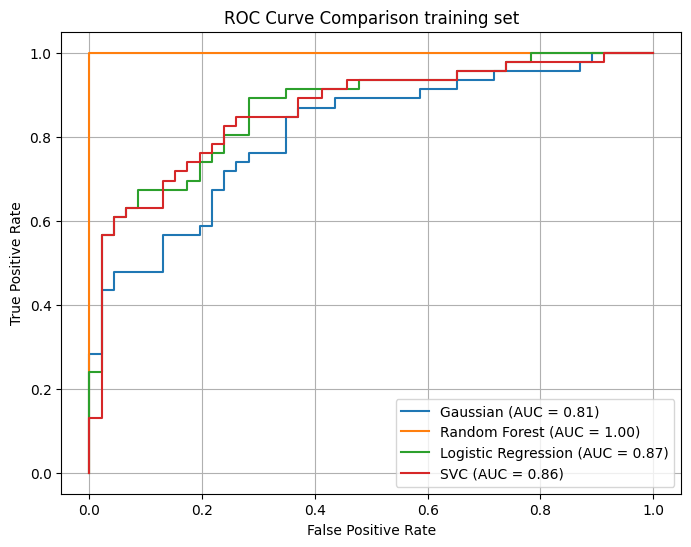

In [ ]:
# Retraining models with the best parameters from GridSearch
best_gnb = GaussianNB(**grid_gnb.best_params_)
best_rf = RandomForestClassifier(**grid_rf.best_params_, random_state=42)
best_lr = LogisticRegression(**grid_lr.best_params_, max_iter=1000)
best_svc = svm.SVC(**grid_svc.best_params_)

# Fit all best models on the full training data
best_gnb.fit(X_train, y_train)
best_rf.fit(X_train, y_train)
best_lr.fit(X_train, y_train)
best_svc.fit(X_train, y_train)

# Classifiers with best models
models = {
    "Gaussian": best_gnb,
    "Random Forest": best_rf,
    "Logistic Regression": best_lr,
    "SVC": best_svc
}

for name, model in models.items():
    y_pred = model.predict(X_train)

    print(f"\n{name} Evaluation:")
    print("Accuracy:", accuracy_score(y_train, y_pred))

# ROC curve train set
plt.figure(figsize=(8, 6))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_train)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_train)
    else:
        continue

    fpr, tpr, _ = roc_curve(y_train, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

# Plotting
plt.title("ROC Curve Comparison train set")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

#### Accuracy


Accuracy Comparison Table:

              Model Train Accuracy Test Accuracy
           Gaussian         72.83%        69.57%
      Random Forest         98.91%        82.61%
Logistic Regression         77.17%        86.96%
                SVC         78.26%        86.96%


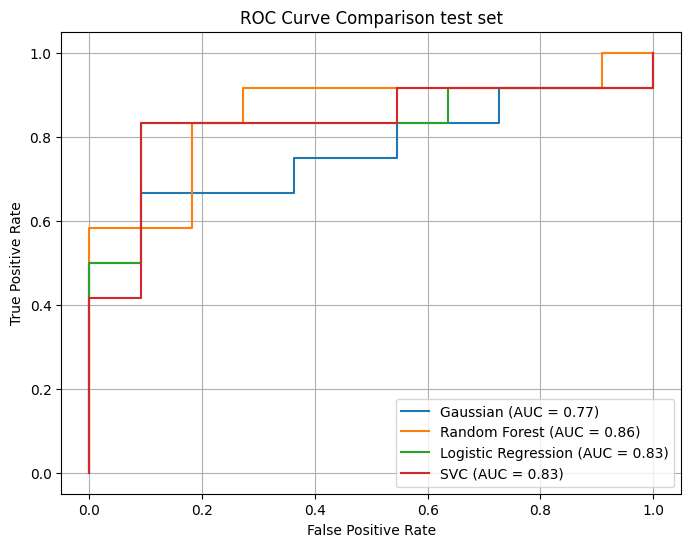

In [59]:
# Evaluate the accuracy
def evaluate_accuracy(model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy * 100:.2f}%")
    return accuracy

# Initialize results list
results = []

# Loop through models and collect accuracy
for name, model in models.items():
    train_acc = accuracy_score(y_train, model.predict(X_train))
    test_acc = accuracy_score(y_test, model.predict(X_test))

    results.append({
        "Model": name,
        "Train Accuracy": f"{train_acc*100:.2f}%",
        "Test Accuracy": f"{test_acc*100:.2f}%"
    })

# Create DataFrame
results_df = pd.DataFrame(results)
print("\nAccuracy Comparison Table:\n")
print(results_df.to_string(index=False))

# ROC curve test set
plt.figure(figsize=(8, 6))

for name, model in models.items():
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        continue

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

# Plotting
plt.title("ROC Curve Comparison test set")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

#### Final Model - Logisctic Regression
Now, our final model looks would look like the underneath code. We are assuming a single sample, with all the same columns as our acquired dataset.

In [60]:
# Gathering (useful) data
random_number = 49 # Use any patient in the the dataset

#Google Colab
dataframe = load_data()

patient = dataframe.iloc[[random_number],:]
data = patient.drop(columns=['label'], inplace=False)

# Scaling features
if sorted(scalers.keys()) != sorted(data.columns):
    raise ValueError("Scaler keys and DataFrame columns do not match.")

df_scaled = []
for column in data.columns:
    column_data = data[column].values.reshape(-1, 1)
    scaled_column = scalers[column].transform(column_data)
    df_scaled.append(pd.Series(scaled_column.flatten(), name=column))
df = pd.concat(df_scaled, axis=1)

# Filtering features
missing_features = [f for f in features if f not in df.columns]
if missing_features:
    raise ValueError(f"The following features are missing from the DataFrame: {missing_features}")

nan_features = [f for f in features if df[f].isnull().any()]
if nan_features:
    raise ValueError(f"The following features contain NaN values: {nan_features}")

df = df[features]

# Prediction
prediction = best_lr.predict(df)
print(f"For patient '{patient.index[0]}' the algorithm predicts: {prediction}") 

For patient 'Lipo-050_0' the algorithm predicts: [0]
